In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from loss_fun import *
from Models import *
import pickle
from evaluator import rank_evaluator
import random
from torch import optim
import gc
import argparse
import copy
from scipy.stats.stats import pearsonr
from joblib import Parallel, delayed
from scipy.stats import rankdata


/tmp/ipykernel_141361/2671805351.py:15: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
def read_data(task, period):

    if period == "bull":
        data_path = "./data/bull_dataset.csv"
        supply_relation_path = "./data/bull_relation.pkl"
    elif period == "bear":
        data_path = "./data/bear_dataset.csv"
        supply_relation_path = "./data/bear_relation.pkl"
    elif period == "mixed":
        data_path = "./data/mixed_dataset.csv"
        supply_relation_path = "./data/mixed_relation.pkl"
    else:
        print("period error")

    with open(supply_relation_path, 'rb') as handle:
        supply_relation = pickle.load(handle)
    # supply_relation = torch.tensor(supply_relation, device=DEVICE)

    market_data = pd.read_csv(data_path)
    num_stock = len(market_data.STOCK_ID.unique())
    num_timestep = len(market_data.date.unique())

    x_col = ['x_earning_rate', 'x_BIDLO_rate', 'x_ASKHI_rate', 'x_turnover',
             'x_SMA5_rate', 'x_SMA15_rate', 'x_SMA30_rate', 'x_MIDPRICE_rate',
             'ADX', 'MACD','AROONOSC', 'PPO','ATR', 'NATR','AD', 'OBV',
             'x_earning_rate_rank', 'x_BIDLO_rate_rank', 'x_ASKHI_rate_rank', 'x_turnover_rank',
             'x_SMA5_rate_rank', 'x_SMA15_rate_rank', 'x_SMA30_rate_rank', 'x_MIDPRICE_rate_rank',
             'x_ADX_rank', 'x_MACD_rank',
             "x_AROONOSC_rank", "x_PPO_rank",
             'x_ATR_rank', 'x_NATR_rank',
             'x_AD_rank', 'x_OBV_rank']

    x_ = market_data[x_col].to_numpy().reshape(num_stock, num_timestep, -1).transpose(1, 0, 2)

    if task == "rank":
        y_ = market_data["y_earning_rate_tmr_rank"].to_numpy().reshape(num_stock, num_timestep).transpose(1, 0)
        y_ret = market_data["y_earning_rate_tmr"].to_numpy().reshape(num_stock, num_timestep).transpose(1, 0)
    elif task == "reg":
#     elif task == "reg":
        y_ = market_data["y_earning_rate_tmr"].to_numpy().reshape(num_stock, num_timestep).transpose(1, 0)
        y_ret = market_data["y_earning_rate_tmr"].to_numpy().reshape(num_stock, num_timestep).transpose(1, 0)
    else:
        print("error")

    return x_, y_, y_ret, supply_relation

In [3]:
def get_data(period):
    rnn_length = 24
    DEVICE = "cuda:0"
    
    x, y , y_ret, supply_relation= read_data(task = "reg", period = period)
    x_train = x[: -512]
    x_eval = x[-512 - rnn_length: -256]
    x_test = x[-256 - rnn_length:]
    
    y_train = y[: -512]
    y_eval = y[-512 - rnn_length: -256]
    y_test = y[-256 - rnn_length:]
    
    y_ret_train = y_ret[: -512]
    y_ret_eval =  y_ret[-512 - rnn_length: -256]
    y_ret_test =  y_ret[-256 - rnn_length:]

    x_test = torch.tensor(x_test, dtype=torch.double,device = DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.double, device = DEVICE).unsqueeze(-1)
    relation = torch.tensor(supply_relation, dtype=torch.double, device=DEVICE)
    return x_test, y_test,y_ret_test, relation

In [5]:
loss_fun = torch.nn.MSELoss()
def evaluate(model, x_eval, relation, y_eval, y_ret_eval):
    model.eval()
    x_eval = torch.tensor(x_eval, dtype=torch.double,device = DEVICE)
    y_eval = torch.tensor(y_eval, dtype=torch.double, device = DEVICE).unsqueeze(-1)
    relation = torch.tensor(relation, dtype=torch.double, device=DEVICE)
    num_sample = (x_eval.size()[0] - rnn_length + 1) * x_eval.size()[1]

    seq_len = len(x_eval)
    seq = list(range(seq_len))[rnn_length - 1:]

    preds = []
    true_ret = []
    total_loss = 0

    for i in seq:
        output = model(x_eval[i - rnn_length + 1: i + 1], relation)
        loss = loss_fun(output, y_eval[i])
        total_loss += loss.item() * x_eval.size()[1]
        preds.append(output.detach().cpu().numpy())
        true_ret.append(y_ret_eval[i])
    metrics, _ , _ = rank_evaluator(np.array(preds).squeeze(),np.array(true_ret))
    metrics["loss"] = total_loss / num_sample
    return metrics

# Bear Check

In [6]:
D_MARKET = 32
hidn_rnn = 64
heads_att = 8
ln = 4
tau = 3
alpha =3 
dropout_p = 0.5
sqmode=0
rnn_length=24
DEVICE = "cuda:0"

Path = "./Saved_Models/bear.model"
model = DRSN(ipt_dim = D_MARKET, t = rnn_length, hid_dim= hidn_rnn, alpha= alpha,lr_num=ln, nheads=heads_att, dropout_p = dropout_p, tau_init=tau, sqmode=sqmode)
model.to(torch.double)
model.to(DEVICE)
model.load_state_dict(torch.load(Path,map_location='cuda:0'))
model.eval()   

df_bear = pd.DataFrame()
period = "bear"
bear_x_test,  bear_y_test, bear_y_ret_test, bear_supply_relation = get_data(period)
sum_ = []
seq_len = len(bear_x_test)
seq = list(range(seq_len))[rnn_length - 1:]
for i in seq:
    r, gate = model.get_spillover_process(bear_x_test[i - rnn_length + 1: i + 1], bear_supply_relation)
    temp_ = gate.abs().mean(axis=0).mean(axis=0)
    sum_ += temp_.detach().cpu().numpy().tolist()
temp = pd.DataFrame(sum_)
temp["period"] = "Bearish"
df_bear = pd.concat([df_bear,temp],axis=0)

In [7]:
evaluate(model, bear_x_test, bear_supply_relation, bear_y_test, bear_y_ret_test)

/tmp/ipykernel_141361/1640271719.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(x_eval, dtype=torch.double,device = DEVICE)
/tmp/ipykernel_141361/1640271719.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval = torch.tensor(y_eval, dtype=torch.double, device = DEVICE).unsqueeze(-1)
/tmp/ipykernel_141361/1640271719.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  relation = torch.tensor(relation, dtype=torch.double, device=DEVICE)
/home/chengrui/anaconda3/envs/python38/lib/python3.8/site-packages/torch/

{'AAR': 0.08957312737251288,
 'AV': 0.5141024367873245,
 'MDD': 0.4795255537711715,
 'EAAR': 0.3040022799674825,
 'EAV': 0.14130071664983998,
 'EMDD': 0.0391611313078158,
 'MRR': 0.02063226014014424,
 'MSE': 0.002153069427505632,
 'loss': 0.0021530897553322715}

In [8]:
df_bear.describe()

,0
count,1.973760e+05
mean,8.121239e-05
std,6.036771e-05
min,4.408979e-08
25%,3.468941e-05
50%,6.999840e-05
75%,1.153078e-04
max,3.286808e-04


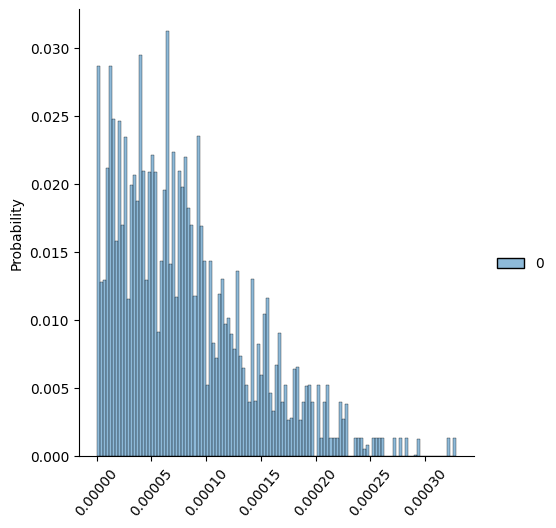

In [26]:
#bear_period_seed_1.model:  1e-4-1e-5, bear_period_seed10.model: 1e-6, bear_period_seed_4.model: 1e-6-1e-7
_ = sns.displot(df_bear,stat="probability")
_ = plt.xticks(rotation=50)

In [10]:
from scipy.stats import kurtosis, skew

data = df_bear[0] 
# skew
data_skew = skew(data)
print("skew: ", data_skew)

# kurtosis
data_kurtosis = kurtosis(data, fisher=True)  # Fisher标准（峰度为0表示与正态分布的峰度相同）
print("kurtosis: ", data_kurtosis)

# 
data_kurtosis_pearson = kurtosis(data, fisher=False)
print("kurtosis_pearson: ", data_kurtosis_pearson)

skew:  0.9764418686598281
kurtosis:  0.7257231009301943
kurtosis_pearson:  3.7257231009301943


In [28]:
import numpy as np

# Sample data list
data = df_bear[0] 

# Function to calculate IQR and identify outliers
def detect_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return outliers

# Calculate outliers using IQR
outliers_iqr = detect_outliers_iqr(data)
print("outlier rate:", len(outliers_iqr) / len(data))

outlier rate: 0.018137970168612193


# Mixed Check

In [12]:
D_MARKET = 32
hidn_rnn = 64
heads_att = 8
ln = 4
tau = 3
alpha =3 
dropout_p = 0.5
sqmode=0
rnn_length=24
DEVICE = "cuda:0"

Path = "./Saved_Models/mixed.model"
model = DRSN(ipt_dim = D_MARKET, t = rnn_length, hid_dim= hidn_rnn, alpha= alpha,lr_num=ln, nheads=heads_att, dropout_p = dropout_p, tau_init=tau, sqmode=sqmode)
model.to(torch.double)
model.to(DEVICE)
model.load_state_dict(torch.load(Path,map_location='cuda:0'))
model.eval()   

df_mixed = pd.DataFrame()
period = "mixed"
mixed_x_test, mixed_y_test,mixed_y_ret_test,mixed_supply_relation = get_data(period)
sum_ = []
seq_len = len(mixed_x_test)
seq = list(range(seq_len))[rnn_length - 1:]
for i in seq:
    r, gate = model.get_spillover_process(mixed_x_test[i - rnn_length + 1: i + 1], mixed_supply_relation)
    temp_ = gate.abs().mean(axis=0).mean(axis=0)
    sum_ += temp_.detach().cpu().numpy().tolist()
temp = pd.DataFrame(sum_)
temp["period"] = "Sideways"
df_mixed = pd.concat([df_mixed,temp],axis=0)

In [13]:
evaluate(model,mixed_x_test, mixed_supply_relation, mixed_y_test, mixed_y_ret_test)

/tmp/ipykernel_141361/1640271719.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(x_eval, dtype=torch.double,device = DEVICE)
/tmp/ipykernel_141361/1640271719.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval = torch.tensor(y_eval, dtype=torch.double, device = DEVICE).unsqueeze(-1)
/tmp/ipykernel_141361/1640271719.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  relation = torch.tensor(relation, dtype=torch.double, device=DEVICE)
/home/chengrui/anaconda3/envs/python38/lib/python3.8/site-packages/torch/

{'AAR': 0.37137202169914674,
 'AV': 0.12619184502760974,
 'MDD': 0.07920264250580797,
 'EAAR': 0.10854728906653932,
 'EAV': 0.050926551157305176,
 'EMDD': 0.03388069635802531,
 'MRR': 0.039146576017123555,
 'MSE': 0.00019609828374536533,
 'loss': 0.00019612877256542155}

In [14]:
df_mixed.describe() 

,0
count,1.973760e+05
mean,1.594727e-04
std,1.225702e-04
min,2.361259e-07
25%,6.137113e-05
50%,1.343830e-04
75%,2.246877e-04
max,6.400199e-04


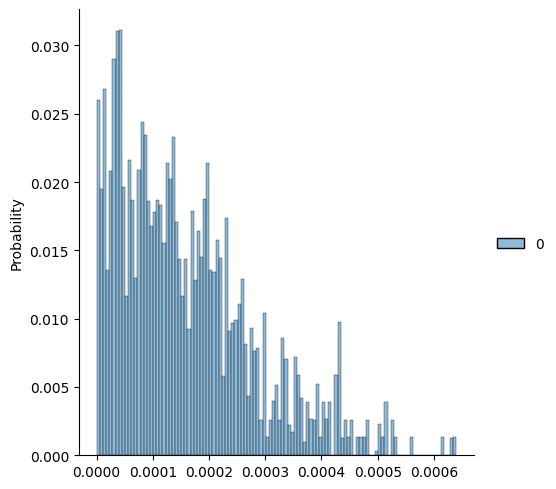

In [30]:
_ = sns.displot(df_mixed,stat="probability")

In [32]:
from scipy.stats import kurtosis, skew

data = df_mixed[0] 
# skew
data_skew = skew(data)
print("skew: ", data_skew)

# kurtosis
data_kurtosis = kurtosis(data, fisher=True)  # Fisher标准（峰度为0表示与正态分布的峰度相同）
print("kurtosis: ", data_kurtosis)

# 
data_kurtosis_pearson = kurtosis(data, fisher=False)
print("kurtosis_pearson: ", data_kurtosis_pearson)

skew:  1.0174451207847657
kurtosis:  0.7745929226108941
kurtosis_pearson:  3.774592922610894


In [31]:
import numpy as np

# Sample data list
data = df_mixed[0] 

# Function to calculate IQR and identify outliers
def detect_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return outliers

# Calculate outliers using IQR
outliers_iqr = detect_outliers_iqr(data)
print("outlier rate:", len(outliers_iqr) / len(data))

outlier rate: 0.020833333333333332


# Bull Check

In [18]:
D_MARKET = 32
hidn_rnn = 64
heads_att = 8
ln = 4
tau = 3
alpha =3 
dropout_p = 0.5
sqmode= 0
rnn_length= 24
DEVICE = "cuda:0"

Path = "./Saved_Models/bull.model"
model = DRSN(ipt_dim = D_MARKET, t = rnn_length, hid_dim= hidn_rnn, alpha= alpha,lr_num=ln, nheads=heads_att, dropout_p = dropout_p, tau_init=tau, sqmode=sqmode)
model.to(torch.double)
model.to(DEVICE)
model.load_state_dict(torch.load(Path,map_location='cuda:0'))
model.eval()   

df_bull = pd.DataFrame()
period = "bull"
bull_x_test, bull_y_test, bull_y_ret_test, bull_supply_relation = get_data(period)
sum_ = []
seq_len = len(bull_x_test)
seq = list(range(seq_len))[rnn_length - 1:]
for i in seq:
    r, gate = model.get_spillover_process(bull_x_test[i - rnn_length + 1: i + 1], bull_supply_relation)
#         temp = torch.bmm(r.unsqueeze(1), gate).squeeze().abs()
#         temp = (x_test[i - rnn_length + 1: i + 1].reshape(-1,768) * gate).abs().sum(dim = 1)
    # temp_ =  gate.abs().sum(axis=-1).sum(axis = 0) / gate.size()[0]
    temp_ = gate.abs().mean(axis=0).mean(axis=0)
#         if sum_ is not None:
    sum_ += temp_.detach().cpu().numpy().tolist()
# print(ind ,ids_[ind[np.argsort(sum_[ind])]] )
temp = pd.DataFrame(sum_)
temp["period"] = "Bullish"
df_bull= pd.concat([df_bull,temp],axis=0)

In [19]:
evaluate(model,bull_x_test, bull_supply_relation, bull_y_test, bull_y_ret_test)

/tmp/ipykernel_141361/1640271719.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval = torch.tensor(x_eval, dtype=torch.double,device = DEVICE)
/tmp/ipykernel_141361/1640271719.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_eval = torch.tensor(y_eval, dtype=torch.double, device = DEVICE).unsqueeze(-1)
/tmp/ipykernel_141361/1640271719.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  relation = torch.tensor(relation, dtype=torch.double, device=DEVICE)
/home/chengrui/anaconda3/envs/python38/lib/python3.8/site-packages/torch/

{'AAR': 0.3292167923500431,
 'AV': 0.15624259365935864,
 'MDD': 0.12006032661104495,
 'EAAR': 0.0948442237524676,
 'EAV': 0.07677195639775818,
 'EMDD': 0.0723655068153289,
 'MRR': 0.05728192700290136,
 'MSE': 0.0002903892177907255,
 'loss': 0.00029040003649191085}

In [20]:
##
df_bull.describe() 

,0
count,1.973760e+05
mean,2.707267e-04
std,2.021867e-04
min,1.180687e-07
25%,1.079910e-04
50%,2.266006e-04
75%,3.974226e-04
max,1.183686e-03


(array([-0.0002,  0.    ,  0.0002,  0.0004,  0.0006,  0.0008,  0.001 ,
         0.0012,  0.0014]),
 [Text(-0.0002, 0, '−0.0002'),
  Text(0.0, 0, '0.0000'),
  Text(0.0002, 0, '0.0002'),
  Text(0.0004000000000000001, 0, '0.0004'),
  Text(0.0006000000000000001, 0, '0.0006'),
  Text(0.0008, 0, '0.0008'),
  Text(0.001, 0, '0.0010'),
  Text(0.0012, 0, '0.0012'),
  Text(0.0014, 0, '0.0014')])

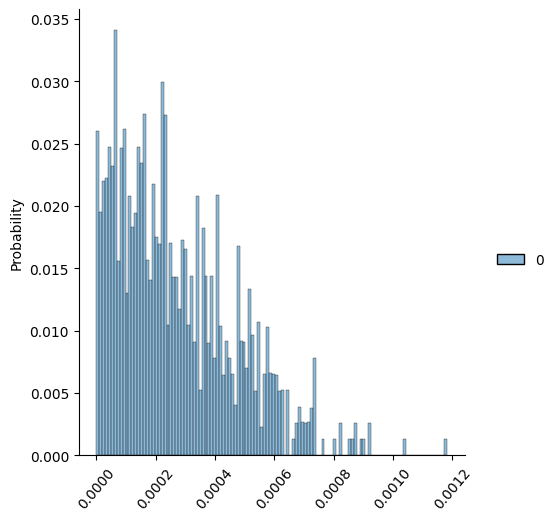

In [33]:
_=sns.displot(df_bull,stat="probability")
plt.xticks(rotation=50)

In [34]:
from scipy.stats import kurtosis, skew

data = df_bull[0] 
# skew
data_skew = skew(data)
print("skew: ", data_skew)

# kurtosis
data_kurtosis = kurtosis(data, fisher=True)  # Fisher标准（峰度为0表示与正态分布的峰度相同）
print("kurtosis: ", data_kurtosis)

# 
data_kurtosis_pearson = kurtosis(data, fisher=False)
print("kurtosis_pearson: ", data_kurtosis_pearson)

skew:  0.9070762676208192
kurtosis:  0.5895305898911345
kurtosis_pearson:  3.5895305898911345


In [35]:
import numpy as np

# Sample data list
data = df_mixed[0] 

# Function to calculate IQR and identify outliers
def detect_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    return outliers

# Calculate outliers using IQR
outliers_iqr = detect_outliers_iqr(data)
print("outlier rate:", len(outliers_iqr) / len(data))

outlier rate: 0.020833333333333332


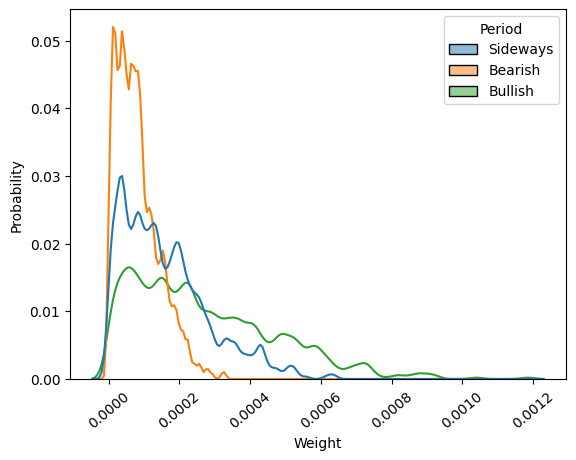

In [37]:
import matplotlib.pyplot as plt
df_all = pd.concat([df_mixed,df_bear,df_bull],axis=0)
df_all.columns = ["Weight", 'Period']
# ax = sns.displot(data=df_all.reset_index(), x="Weight", hue="Period", kind="hist", stat="probability",height=4,aspect=2.0)
# ax = sns.displot(data=df_all.reset_index(), x="Weight", hue="Period", stat="probability",height=3.0,aspect=1.0,fill=True)
ax = sns.histplot(data=df_all.reset_index(), x="Weight",  hue="Period", kde=True, stat="probability", label="Probabilities",
                  binwidth=0.00002,kde_kws={'cut': 4})
ax.containers[0].remove() # remove the bars
ax.containers[0].remove() # remove the bars
ax.containers[0].remove() # remove the bars
_ = plt.xticks(rotation=40)
# sns.displot(data=df_all.reset_index(), x="Weight", hue="Period", stat="probability")
# plt.ylim(0, 0.1)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(0.6, 0.8))
# plt.savefig("./gatedis.png",bbox_inches = 'tight')

# Date importance

In [42]:
def get_model(period):
    if period == "bull":
        Path= "./Saved_Models/bull.model"
    elif period =="bear":
        Path= "./Saved_Models/bear.model"
    elif period =="mixed":
        Path= "./Saved_Models/mixed.model"
    else:
        Path = None
    model = DRSN(ipt_dim = D_MARKET, t = rnn_length, hid_dim= hidn_rnn, alpha= alpha,
              lr_num=ln, nheads=heads_att, dropout_p = dropout_p, tau_init=tau, sqmode=sqmode)

    model.to(torch.double)
    model.to(DEVICE)
    model.load_state_dict(torch.load(Path,map_location='cuda:0'))
    model.eval()   
    return model

In [43]:
# 比较3个时期的滞后期数
df_0 = pd.DataFrame()
for period in ["bear","bull","mixed"]:
    model = get_model(period)
    x_test, _,_, relation = get_data(period)
    sum_ = None
    seq_len = len(x_test)
    seq = list(range(seq_len))[rnn_length - 1:]
    for i in seq:
        r, gate = model.get_spillover_process(x_test[i - rnn_length + 1: i + 1], relation)
        temp =  gate.reshape(-1,24,32).abs().sum(dim = -1).mean(axis=0)
        if sum_ is not None:
            sum_ += temp.detach().cpu().numpy()
        else: 
            sum_ = temp.detach().cpu().numpy()
    sum_ = np.abs(sum_ / seq_len)
    temp = pd.DataFrame(sum_.reshape(-1))
    temp["period"] = period
    temp["date"] = list(range(24))
    df_0 = pd.concat([df_0,temp],axis=0)

/tmp/ipykernel_141361/1436562793.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]


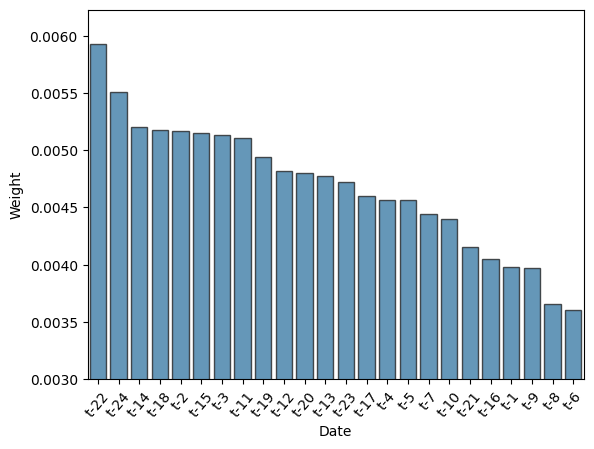

In [44]:
df_0.columns = ["Weight", 'Period',"Date"]
draw_df  = df_0[df_0["Period"] == "mixed"]
draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]
draw_df  = draw_df.sort_values('Weight',ascending=False).reset_index()
sns.barplot(data = draw_df, x = "Date", y = "Weight", order=draw_df['Date'],color = sns.color_palette()[0], alpha=0.75, linewidth=1.0, edgecolor="0.1")
# plt.ylim(4.5e-5, 9.2e-5)
_ = plt.xticks(rotation=50)
_ = plt.ylim(0.003)
plt.savefig("./mixedDate.png",bbox_inches = 'tight')

/tmp/ipykernel_141361/1192711672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]


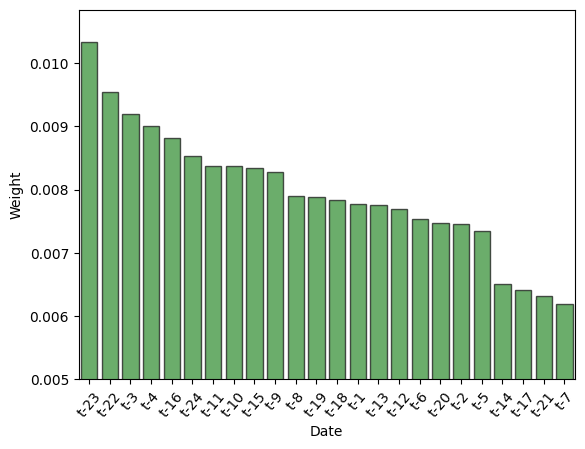

In [45]:
df_0.columns = ["Weight", 'Period',"Date"]
draw_df  = df_0[df_0["Period"] == "bull"]
draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]
draw_df  = draw_df.sort_values('Weight',ascending=False).reset_index()
sns.barplot(data = draw_df, x = "Date", y = "Weight", order=draw_df['Date'],color = sns.color_palette()[2], alpha=0.75, linewidth=1.0, edgecolor="0.1")
# plt.ylim(4, 9.2e-5)
# plt.xticks(rotation=50)
_ = plt.xticks(rotation=50)
_ = plt.ylim(0.005)
plt.savefig("./bullDate.png",bbox_inches = 'tight')

/tmp/ipykernel_141361/3367851129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]


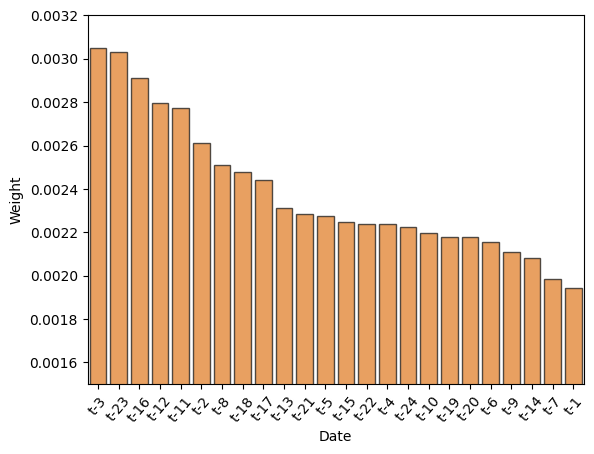

In [46]:
df_0.columns = ["Weight", 'Period', "Date"]
draw_df  = df_0[df_0["Period"] == "bear"]
draw_df["Date"]=["t-{}".format(str(x)) for x in range(1,25)][::-1]
draw_df  = draw_df.sort_values('Weight',ascending=False).reset_index()
sns.barplot(data = draw_df, x = "Date", y = "Weight",order=draw_df['Date'],color = sns.color_palette()[1], alpha=0.75, linewidth=1.0, edgecolor="0.1")
# plt.ylim(4.5e-5, 9.2e-5)
_, plt.xticks(rotation=50)
_ = plt.ylim(0.0015)
plt.savefig("./bearDate.png",bbox_inches = 'tight')